In [2]:
import pandas as pd
import tensorflow as tf

from window import WindowGenerator
from utils import train_test_val_split

In [3]:
def train_case(case_df, model, in_width, out_steps, max_epochs):
    """ Train model for given case df. """
    
    outlets = [ col for col in case_df.columns.values if col.startswith('outlet') ]
    column_indices = { name: i for i, name in enumerate(case_df.columns) }

    train_df, test_df, val_df = train_test_val_split(case_df)
    # train_df, test_df, val_df = normalize_datasets(train_df, test_df, val_df)
    print(train_df.shape)
    print(test_df.shape)
    print(val_df.shape)

    label_columns = outlets

    multi_window = WindowGenerator(
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        input_width=in_width,
        label_width=out_steps,
        shift=out_steps,
        label_columns=label_columns
    )

    history = model.fit(
        multi_window.train,
        epochs=max_epochs,
        validation_data=multi_window.val,
        verbose=0
        # callbacks=[early_stopping]
    )

    return multi_window, history

In [4]:
def plot_losses(history):
    losses = pd.DataFrame(history.history)

    losses[['loss', 'val_loss']].plot(figsize=(10,8), xlabel="Epoch", ylabel="Loss", title="Model loss")
    losses[['root_mean_squared_error', 'val_root_mean_squared_error']].plot(figsize=(10,8), xlabel="Epoch", ylabel="RMSE", title="RMSE")


## Dataset

In [5]:
case_1 = pd.read_csv("../datasets/case_1.csv")
case_2 = pd.read_csv("../datasets/case_2.csv")
case_3 = pd.read_csv("../datasets/case_3.csv")
case_4 = pd.read_csv("../datasets/case_4.csv")
case_5 = pd.read_csv("../datasets/case_5.csv")

In [6]:
outlets = [ col for col in case_1.columns.values if col.startswith('outlet') ]
label_columns = outlets

In [7]:
column_indices = { name: i for i, name in enumerate(case_1.columns) }

## Model creation

In [8]:
IN_WIDTH = 8
OUT_STEPS = 8
MAX_EPOCHS = 20
features_size = len(label_columns)

print(f"Using {IN_WIDTH*5}s of data to predict {OUT_STEPS*5}s into de future.")
print(f"Using {IN_WIDTH*5/60}min of data to predict {OUT_STEPS*5/60}min into de future.")

Using 40s of data to predict 40s into de future.
Using 0.6666666666666666min of data to predict 0.6666666666666666min into de future.


In [9]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(20, activation='relu'), # 512
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*features_size,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, features_size])
])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-08-30 09:30:26.270386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-30 09:30:26.270692: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
multi_linear_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.RootMeanSquaredError()])

## Case 1

In [11]:
window, history = train_case(case_1, multi_linear_model, IN_WIDTH, OUT_STEPS, MAX_EPOCHS)

(128, 272)
(19, 272)
(36, 272)


2022-08-30 09:30:27.075140: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-30 09:30:27.665678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 09:30:30.066660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [12]:
multi_linear_model.build(input_shape=window.example[0].shape)
multi_linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 272)            0         
                                                                 
 dense (Dense)               (None, 1, 20)             5460      
                                                                 
 dense_1 (Dense)             (None, 1, 1088)           22848     
                                                                 
 reshape (Reshape)           (None, 8, 136)            0         
                                                                 
Total params: 28,308
Trainable params: 28,308
Non-trainable params: 0
_________________________________________________________________


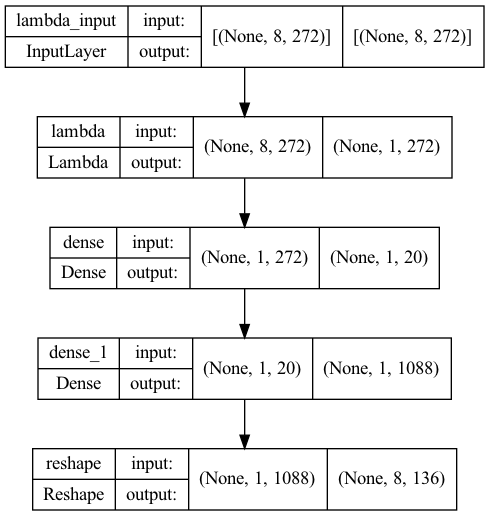

In [13]:
tf.keras.utils.plot_model(multi_linear_model, "../plots/models/multi_lineal.png", show_shapes=True)

label_col_index 135
label_col_index 135


2022-08-30 09:30:39.016675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


label_col_index 135


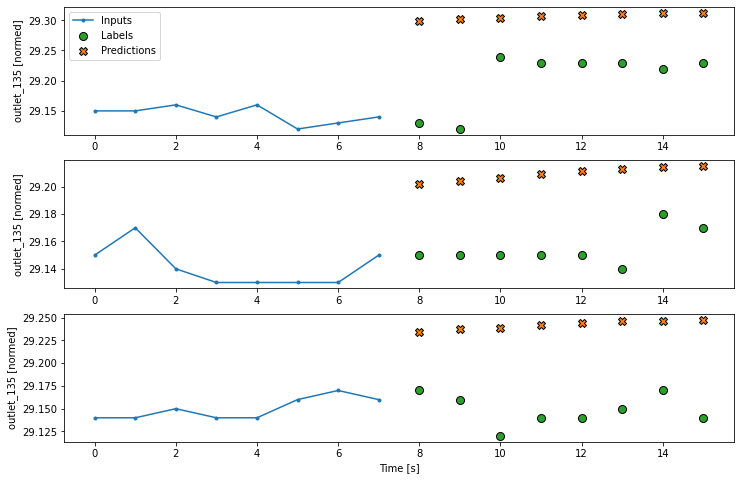

In [14]:
window.plot(multi_linear_model, plot_col="outlet_135")

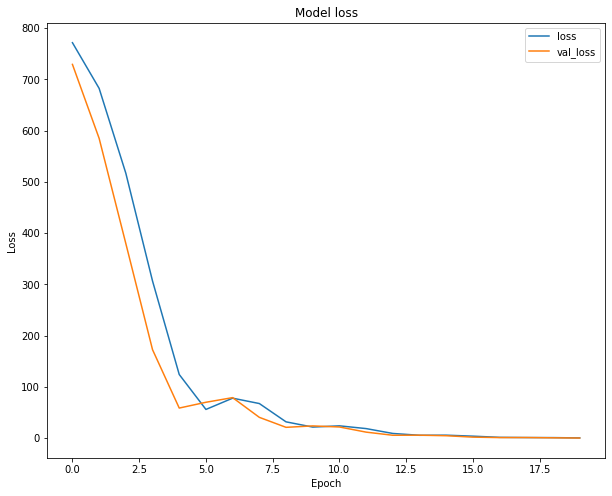

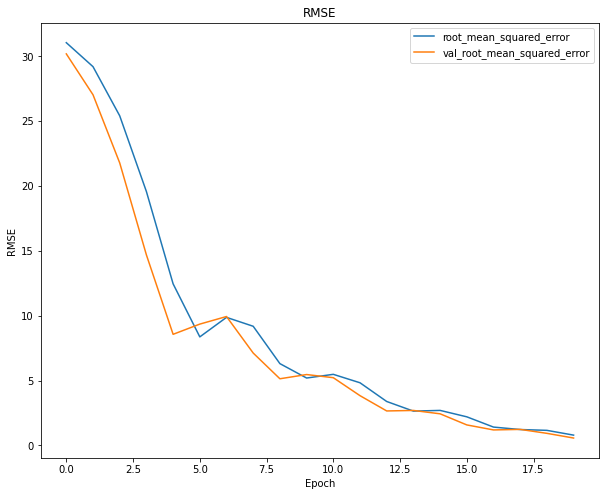

In [15]:
plot_losses(history=history)

In [16]:
# window.test
multi_linear_model.evaluate(window.test)

1/1 [==============================] - 0s 338ms/step - loss: 0.2404 - root_mean_squared_error: 0.5489


[0.24039605259895325, 0.5489460825920105]

## Case 2

In [17]:
window, history = train_case(case_2, multi_linear_model, IN_WIDTH, OUT_STEPS, MAX_EPOCHS)

(142, 272)
(21, 272)
(41, 272)


label_col_index 135
label_col_index 135
label_col_index 135


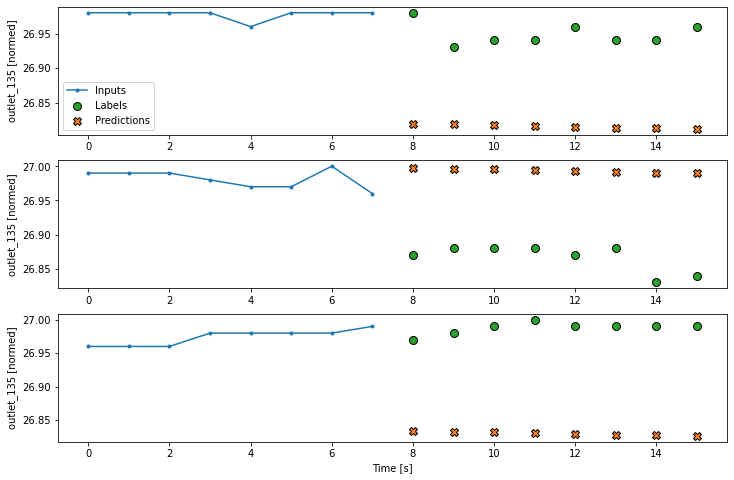

In [18]:
window.plot(multi_linear_model, plot_col="outlet_135")

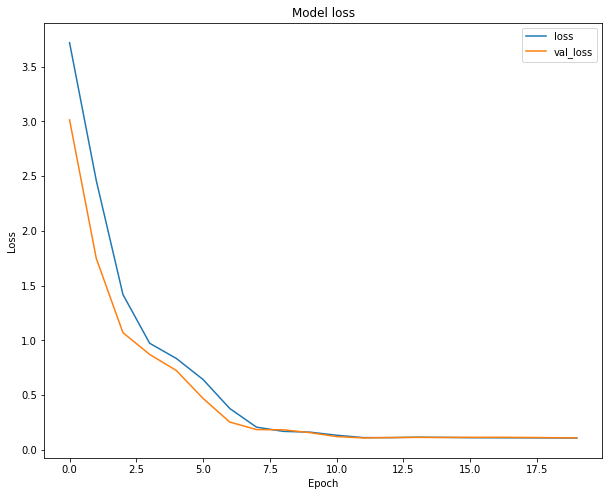

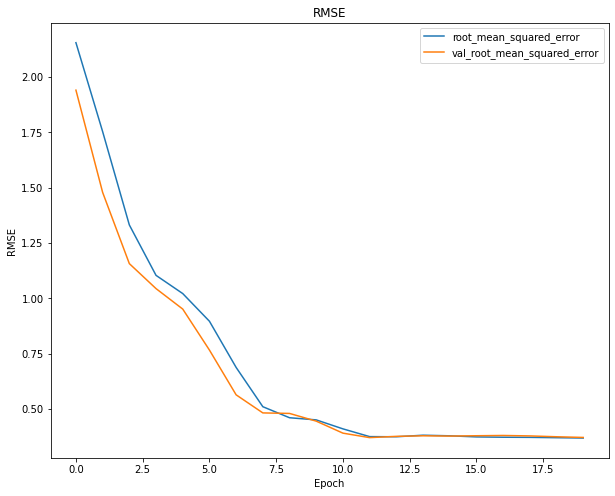

In [19]:
plot_losses(history=history)

In [20]:
# window.test
multi_linear_model.evaluate(window.test)

1/1 [==============================] - 0s 339ms/step - loss: 0.1079 - root_mean_squared_error: 0.3631


[0.1079460084438324, 0.36312374472618103]

## Case 3

In [21]:
window, history = train_case(case_3, multi_linear_model, IN_WIDTH, OUT_STEPS, MAX_EPOCHS)

(147, 272)
(22, 272)
(42, 272)


label_col_index 135
label_col_index 135
label_col_index 135


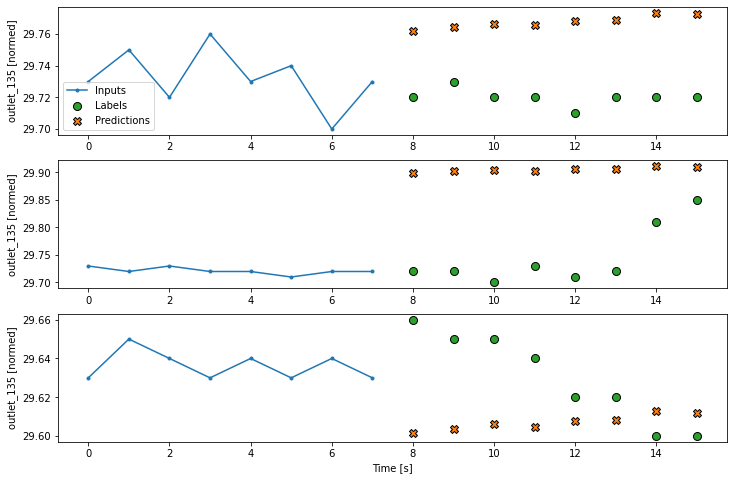

In [22]:
window.plot(multi_linear_model, plot_col="outlet_135")

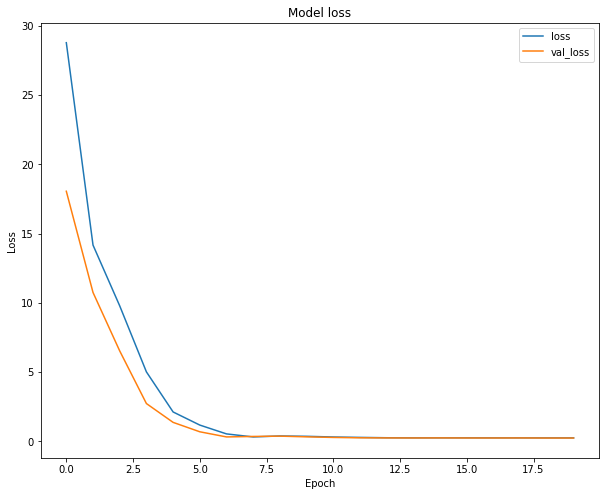

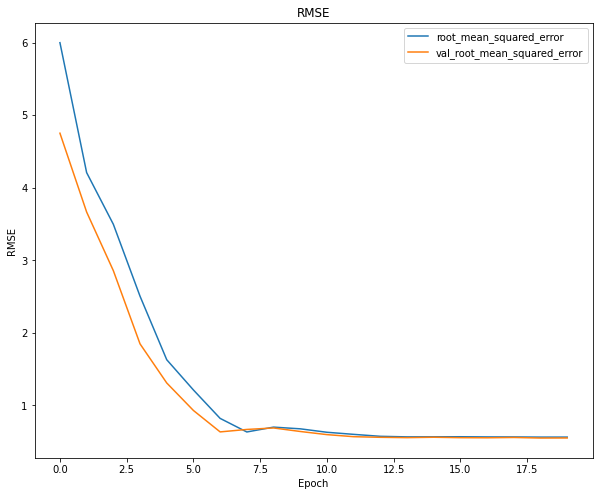

In [23]:
plot_losses(history=history)

In [24]:
multi_linear_model.evaluate(window.test)

1/1 [==============================] - 0s 357ms/step - loss: 0.2191 - root_mean_squared_error: 0.5310


[0.21910664439201355, 0.5310104489326477]

## Case 4

In [25]:
window, history = train_case(case_4, multi_linear_model, IN_WIDTH, OUT_STEPS, MAX_EPOCHS)

(259, 272)
(38, 272)
(74, 272)


label_col_index 135
label_col_index 135
label_col_index 135


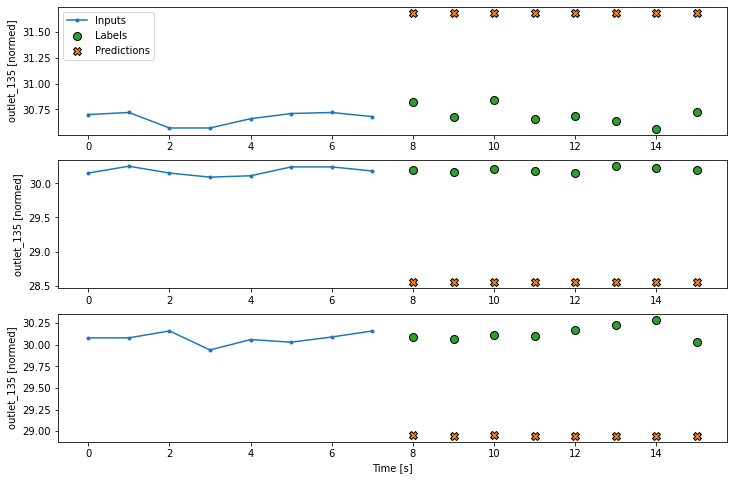

In [26]:
window.plot(multi_linear_model, plot_col="outlet_135")

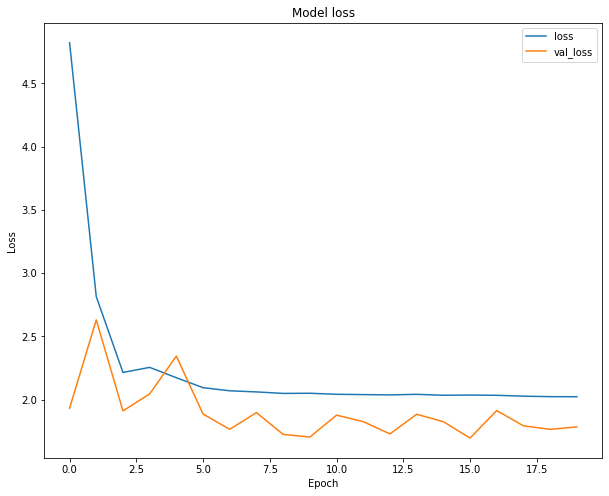

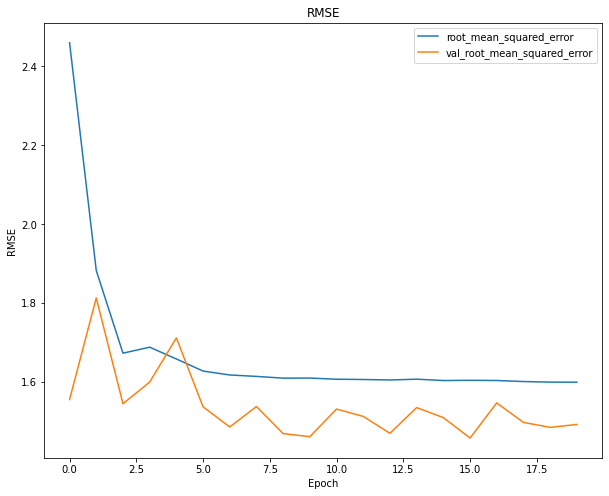

In [27]:
plot_losses(history=history)

In [28]:
multi_linear_model.evaluate(window.test)

1/1 [==============================] - 0s 259ms/step - loss: 1.8583 - root_mean_squared_error: 1.5179


[1.8582690954208374, 1.5178532600402832]

## Case 5

In [29]:
window, history = train_case(
    case_df=case_5,
    model=multi_linear_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

(548, 272)
(79, 272)
(156, 272)


label_col_index 135
label_col_index 135
label_col_index 135


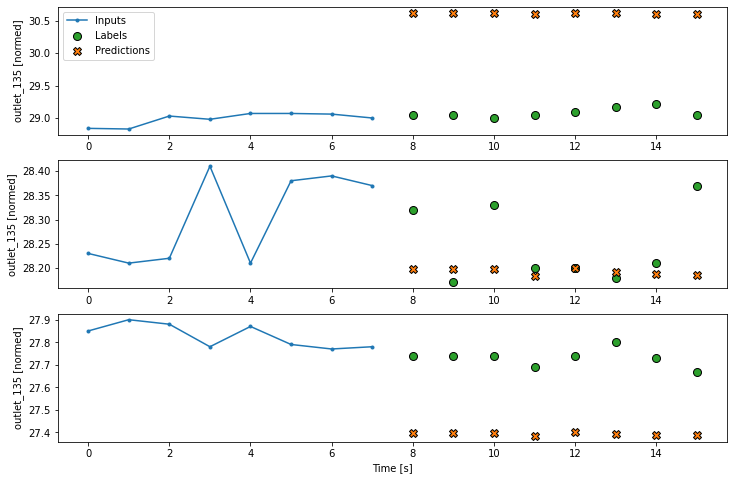

In [30]:
window.plot(multi_linear_model, plot_col="outlet_135")

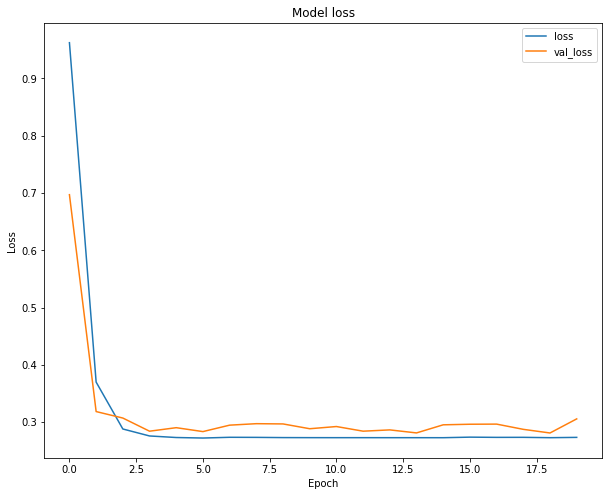

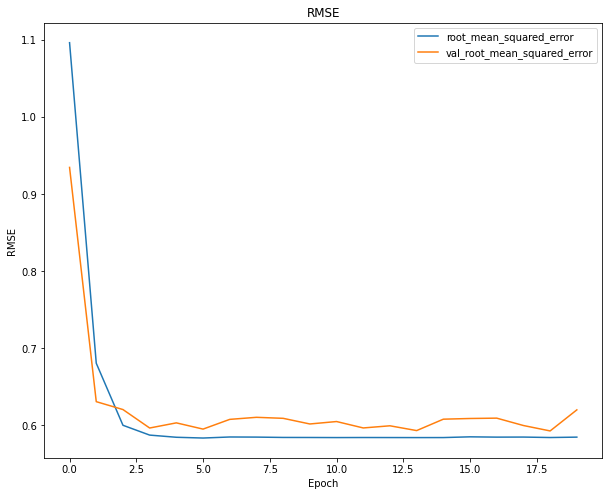

In [31]:
plot_losses(history=history)

In [32]:
multi_linear_model.evaluate(window.test)

2/2 [==============================] - 0s 7ms/step - loss: 0.4057 - root_mean_squared_error: 0.7144


[0.4056955575942993, 0.7143656611442566]